In [3]:
import re

layer_re = re.compile(
    r"INFO layer (\d+?) iter (\d+?) loss:(nan|[\.\d]+?) norm:(nan|[\.\d]+?) max memory_allocated ([\.\d]+)")
task_re = re.compile(r"INFO \{.*?'results': (.+?), 'versions'")
ppl_re = re.compile(r"INFO (wikitext2|(?:ptb|c4)(?:-new)?) : ([\.\d]+)")


test_layer_re = "[2025-03-11 17:27:43 root] (RLQuant.py 236): INFO layer 0 iter 0 loss:0.023954108357429504 norm:0.28997743129730225 max memory_allocated 16404.5771484375 \n"
print(layer_re.search(test_layer_re).groups())

test_task_re = "[2025-03-27 15:32:14 root] (main.py 201): INFO {'wikitext2': 19.50642967224121, 'ptb': 104.68843078613281, 'c4': 23.896516799926758, 'ptb-new': 118.22755432128906, 'c4-new': 25.69214630126953, 'results': {'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}, 'versions': {'arc_challenge': 0, 'arc_easy': 0, 'hellaswag': 0, 'boolq': 1, 'piqa': 0, 'winogrande': 0}, 'config': {'model': <models.LMClass.LMClass object at 0x7b9b10dd7a90>, 'model_args': None, 'num_fewshot': 0, 'limit': None, 'bootstrap_iters': 100000, 'description_dict': None}}"
test_task_re_result = task_re.search(test_task_re).groups()[0]
print(eval(test_task_re_result))

test_ppl_re = "[2025-03-17 09:45:40 root] (main.py 186): INFO wikitext2 : 12.18686580657959"
print(ppl_re.search(test_ppl_re).groups())

('0', '0', '0.023954108357429504', '0.28997743129730225', '16404.5771484375')
{'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}
('wikitext2', '12.18686580657959')


In [11]:
import os

model_name_prefix = "llama-2-7b-hf-w4a4-"
ignore_models = None
# allowd_models = N|one
allowd_models = [
    "base",
    "base-ep1",
    "base4",
    "base-new",
    # "ep1-ns1",
    "sw-none",
    "sw-none-ep1",
    # "sw-last",
    # "sw-full",
]

results = {}

for model_name_orig in os.listdir("../log"):
    model_name = model_name_orig[len(model_name_prefix):]
    if allowd_models is not None and model_name not in allowd_models: continue
    if ignore_models is not None and model_name in ignore_models: continue
    
    model_path = os.path.join(os.getcwd(), "..", "log", model_name_orig)

    for log_filename in os.listdir(model_path):
        if log_filename.endswith(".pth"):
            continue

        log_path = os.path.join(model_path, log_filename)
        print(f"processing file {log_path}")

        with open(log_path, "r") as log_file:
            while line := log_file.readline():
                # if match_result := layer_re.search(line):
                #     layer, iter, loss, norm, max_memory_allocated = match_result.groups()

                #     model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                #     layers = model_loss_dict["layers"]
                #     if len(layers) <= int(layer):
                #         layers.append([])
                #     layers[int(layer)].append((loss, norm, max_memory_allocated))
                # el
                if match_result := task_re.search(line):
                    task_result = eval(match_result.groups()[0])

                    model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                    model_loss_dict["tasks"].append(task_result)
                elif match_result := ppl_re.search(line):
                    ppl_dataset, value = match_result.groups()

                    model_loss_dict = results.setdefault(model_name, {"layers": [], "tasks": [], "ppl": []})
                    model_loss_dict["ppl"].append((ppl_dataset, float(value)))

print(results)
                    

processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base4/log_rank0_1743079688.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-sw-none/log_rank0_1743050795.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base-ep1/log_rank0_1742265890.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base-ep1/log_rank0_1742402885.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base-new/log_rank0_1743086813.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base-new/log_rank0_1743086795.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-base-new/log_rank0_1743086790.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-sw-none-ep1/log_rank0_1743087990.txt
processing file /home/jhkim/workspace/lrquant/scripts/../log/llama-2-7b-hf-w4a4-sw-none-e

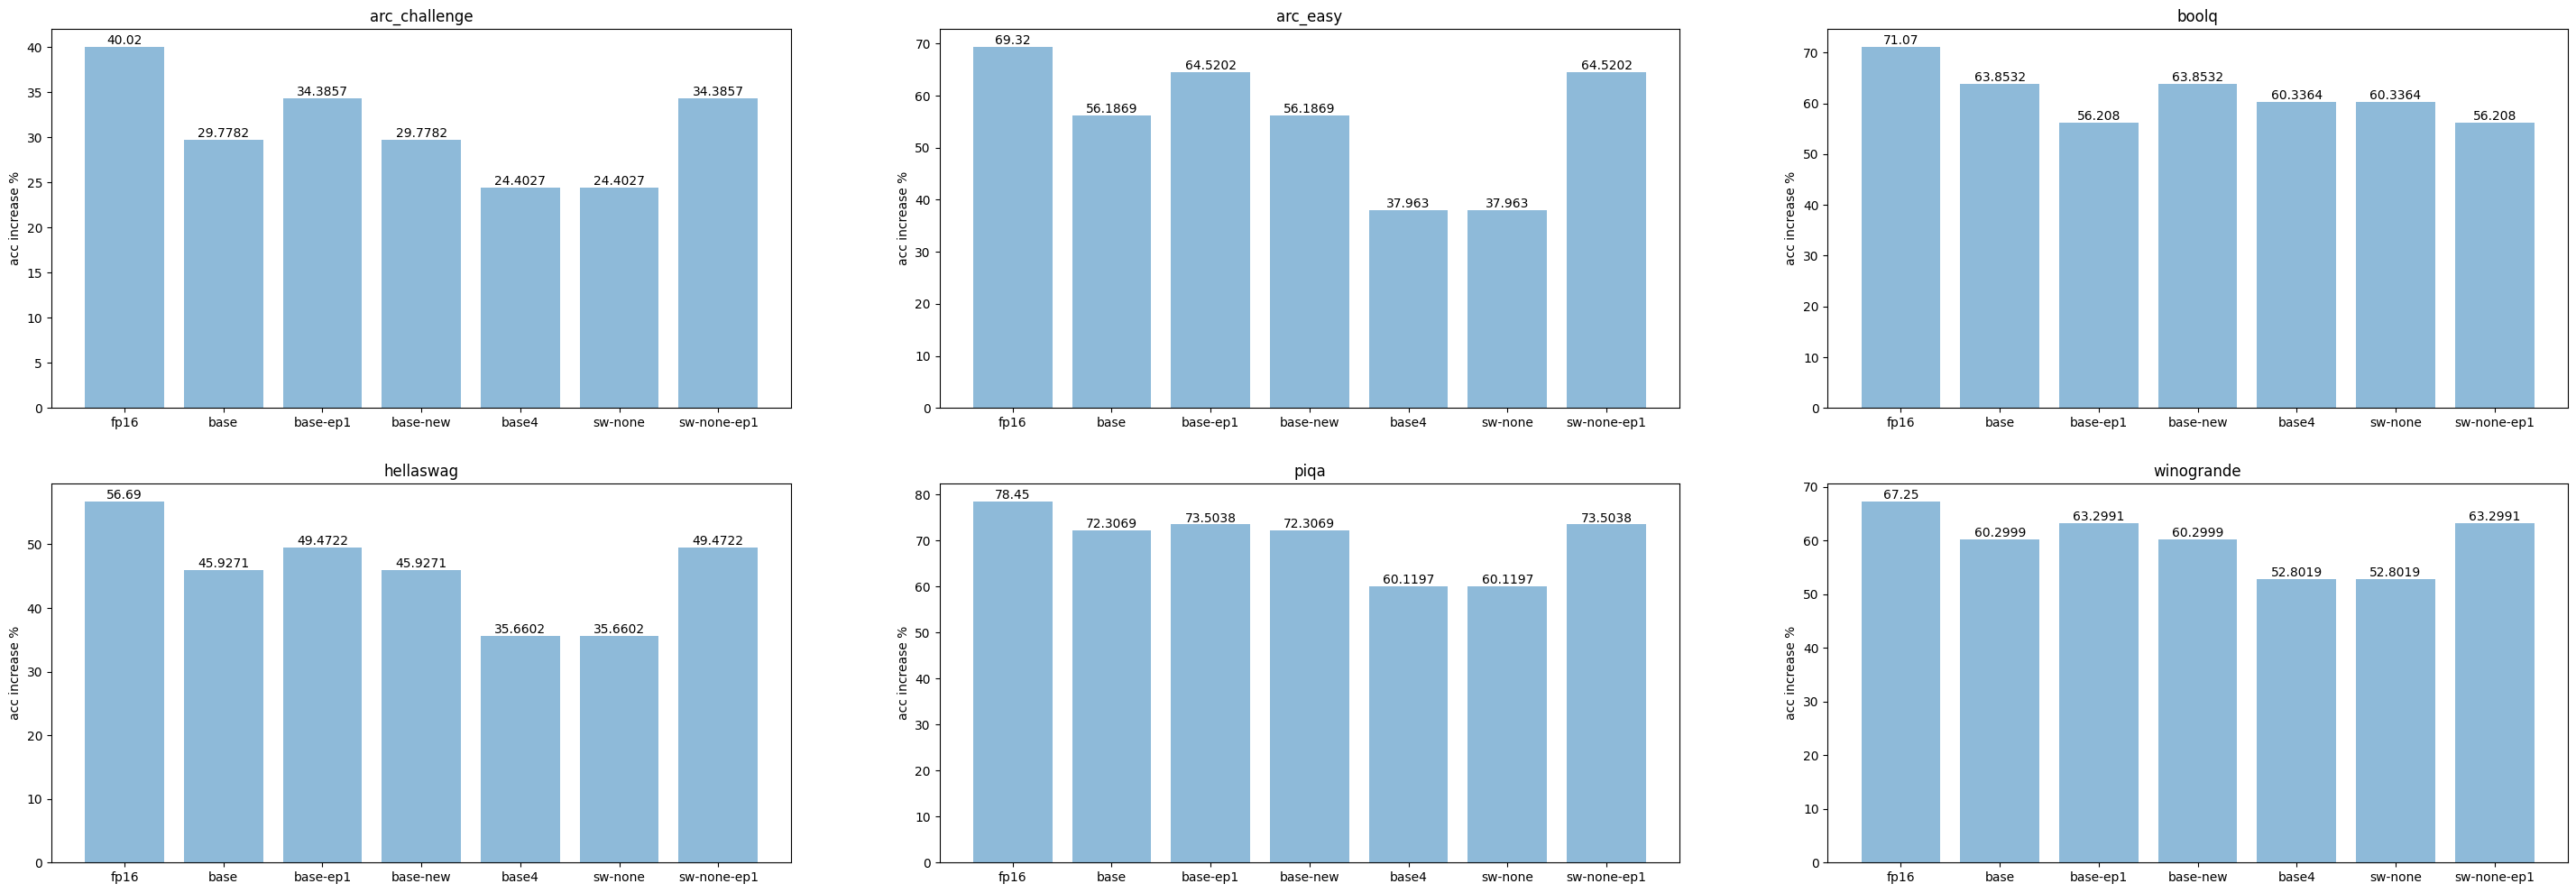

In [12]:
import matplotlib.pyplot as plt
import numpy as np
    
task_model_dict = {}
for key, item in sorted(results.items()):
    if not "tasks" in item or len(item["tasks"]) == 0: continue
    
    tasks = item["tasks"][0]
    for task_name, task_result in sorted(tasks.items()):
        if not task_name in task_model_dict:
            task_model_dict.setdefault(task_name, [])

        task_model_dict[task_name].append((key, task_result['acc']))

fp_16_results = {
    "piqa": 0.7845,
    "arc_easy": 0.6932,
    "arc_challenge": 0.4002,
    "boolq": 0.7107,
    "hellaswag": 0.5669,
    "winogrande": 0.6725,
}
# base_results = {
#     "piqa": 0.6371,
#     "arc_easy": 0.4696,
#     "arc_challenge": 0.2627,
#     "boolq": 0.6339,
#     "hellaswag": 0.4442,
#     "winogrande": 0.5319
# }


fig = plt.figure(figsize=(len(results)*len(task_model_dict), 12))

for idx, (task, model_result) in enumerate(task_model_dict.items()):
    ax = fig.add_subplot(2, len(task_model_dict)//2, (idx+1))
    ax.set_title(task)
    ax.set_ylabel("acc increase %")

    base_result = next(
        (value for name, value in model_result if name == "base"), None)
    if base_result is None:
        raise KeyError("cannot find base result")
    # base_result = base_results[task]
    
    model_result = [("fp16", fp_16_results[task]), *model_result]
    names, values = zip(*((name, value) for name, value in model_result))
    values = np.array(values)

    rect = ax.bar(names, (values)*100, align='center', alpha=0.5)
    ax.bar_label(rect)

plt.show()

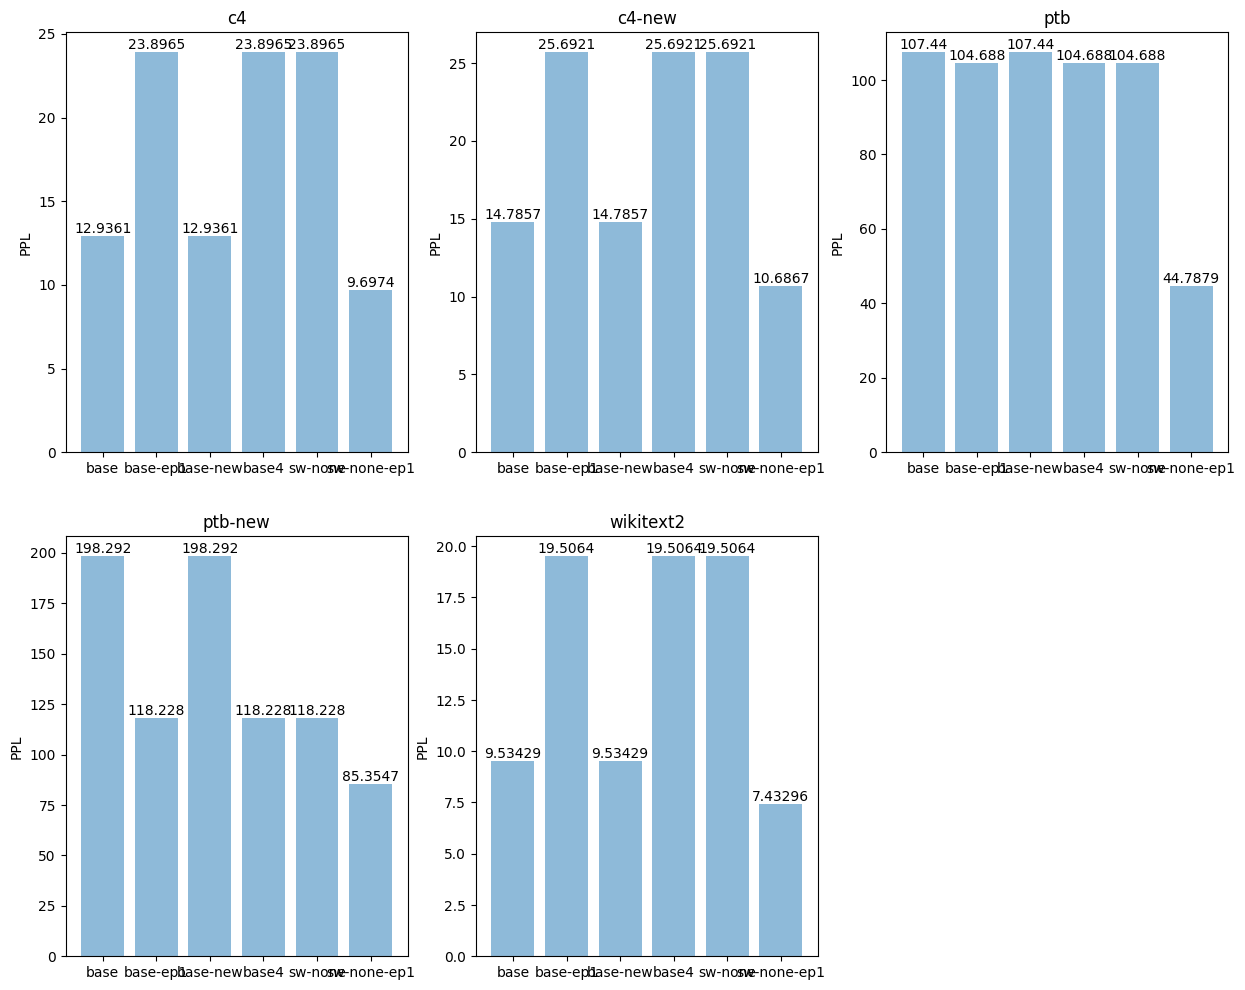

In [13]:
ppl_model_dict = {}
for key, item in sorted(results.items()):
    if not "ppl" in item or len(item["ppl"]) == 0:
        continue

    ppl = item["ppl"]
    for ppl_name, ppl_result in sorted(ppl, key=lambda x: x[0]):
        if not ppl_name in ppl_model_dict:
            ppl_model_dict.setdefault(ppl_name, [])

        ppl_model_dict[ppl_name].append((key, ppl_result))


base_results = {
    "wikitext2": 12.75,
    "ptb": 87.63,
    "c4": 15.82,
    "ptb-new": 281.41,
    "c4-new": 17.57
}

fig = plt.figure(figsize=(len(results)*len(ppl_model_dict)//2, 12))

for idx, (ppl_name, model_result) in enumerate(ppl_model_dict.items()):
    ax = fig.add_subplot(2, (len(ppl_model_dict)+1)//2, (idx+1))
    ax.set_title(ppl_name)
    ax.set_ylabel("PPL")

    # base_result = next((value for name, value in model_result if name == "base"), None)
    # if base_result is None: raise KeyError(f"cannot find base result for ppl {ppl_name}")
    # base_result = base_results[ppl_name]
    names, values = zip(*((name, value) for name, value in model_result))
    values = np.array(values)

    rect = ax.bar(names, values, align='center', alpha=0.5)
    ax.bar_label(rect)

plt.show()